In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
batch_size = 40
img_height = 200
img_width = 200
tf.version.VERSION

Keras dataset preprocessing utilities, located at tf.keras.preprocessing, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

See https://keras.io/api/preprocessing/

Once the dataset is preprocessed and loaded, it can be directly used in calls to model.fit



In [ ]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/MaskNoMask',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

In [ ]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'data/MaskNoMask',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

In [ ]:
training_ds

In [ ]:
class_names = training_ds.class_names
class_names

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [ ]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
from keras.models import Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import datetime

# Michaels Model

inputs = Input(shape=(200, 200, 3))


x = layers.experimental.preprocessing.Rescaling(1.0 / 255)
x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual



x = layers.Dropout(0.25)(x)
x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(150, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(150, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(150, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.Dropout(0.25)(x)
x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(300, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(300, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(300, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.Dropout(0.25)(x)
x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(500, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(500, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(500, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(800, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(800, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(800, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(1000, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)
x = layers.SeparableConv2D(1000, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

# Project residual
residual = layers.Conv2D(1000, 1, strides=2, padding="same")(
    previous_block_activation
)
x = layers.add([x, residual])  # Add back residual
previous_block_activation = x  # Set aside next residual




x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
activation = "sigmoid"
units = 1

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units, activation=activation)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    training_ds, epochs=3, validation_data=testing_ds,
)

# My Model

In [ ]:
#My Model
loss = 'categorical_crossentropy'
opt = Adam(lr=.001)

inputs = Input(shape=(img_width, img_height, 3))

# 2 Convolutional layers each followed by max pooling
x = Conv2D(32, kernel_size=(5, 5), kernel_initializer='he_normal')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Here we'll add a single Dense layer before the prediction
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

In [ ]:
opt = keras.optimizers.Adam(learning_rate=1e-6)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
             metrics=['accuracy'])


model.fit(training_ds, epochs=10,
          batch_size=batch_size,
          validation_data=testing_ds,
          callbacks=[tensorboard_callback]
)

In [ ]:
%load_ext tensorboard
# Clear any logs from previous runs
#rm -rf ./logs/
%tensorboard --logdir logs/fit

# Now build a deep neural network and train it and see how you do

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
Y_pred = model.predict(testing_ds)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]
y_true = np.concatenate([y for x, y in testing_ds], axis=0)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

In [ ]:
model.save('MichaelModelMNM')

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
import matplotlib.image as mpimg

In [14]:
labels = ["Without Mask", "With Mask"]
def classify(img_path, saved_model='../MarshalMaskNoMaskModel'):
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    model = model = tf.keras.models.load_model(saved_model, compile = True)
    prediction = model.predict(img_preprocessed)
    
    prediction_classes = prediction[0]
    prediction_classes = prediction_classes[0]
    prediction_classes = int(round(prediction_classes))
    predicted_label = labels[prediction_classes]
    
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    print(prediction)
    print(predicted_label)


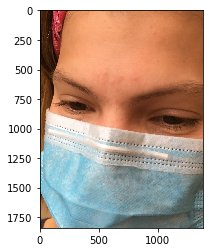

[[0.09772995]]
Without Mask


In [33]:
classify("newData/2IMG_8241.jpg")